In [1]:
from lowres_MVEE import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##### Generate some 2D test data

In [2]:
nD = 2
n_pts = 1000
pts = np.random.randn(nD,n_pts)

##### Compute the MVEE using Khachiyan's Algorithm

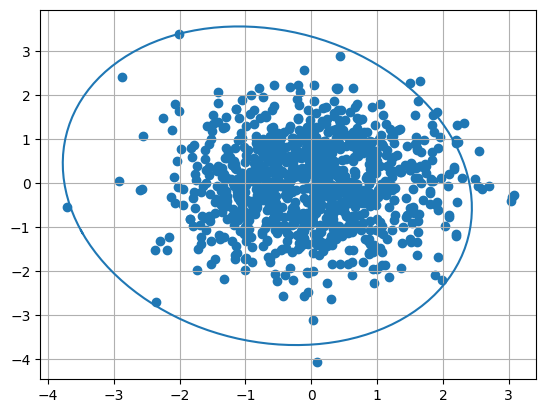

In [3]:
A, c = min_vol_ellipse(pts,tolerance=1e-1)
[D, P] = np.linalg.eig(A)
radii = 1 / np.sqrt(D)

fig = plt.figure()
ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
scatter_nD(pts,ax)
ellipse_plot(A,c,ax)
ax.grid('true')
# ax.axis('equal')
plt.show()

Notice how it's not bounding. We need to address this first.

#### Scale this MVEE so that it actually encloses the points

Undo the transformation defined by (A,c) s.t. the ellipse is mapped to the unit circle. Apply this same transformation to our data.

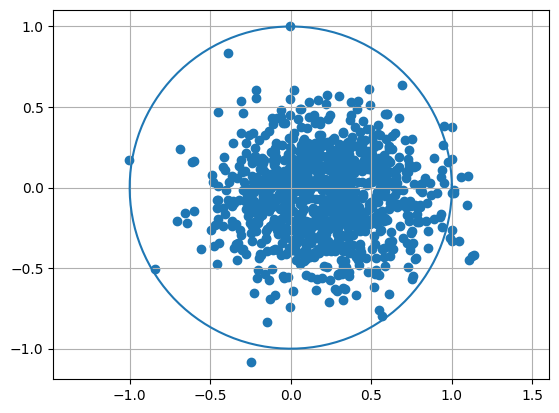

In [4]:
tm = np.diagflat(np.sqrt(D)) @ P.T
pts_mapped_to_unit_sphere = tm @ (pts-c)

fig = plt.figure()
ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
ax.grid('true')
ax.axis('equal')
scatter_nD(pts_mapped_to_unit_sphere,ax)
ellipse_plot(np.eye(nD),np.zeros_like(c),ax)
# plt.show()

Scale the unit circle so it encompasses the points.

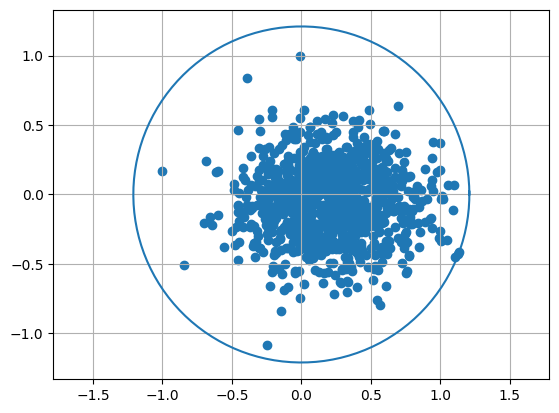

In [5]:
radial_scaling_to_correct_undershoot = np.max(np.linalg.norm(pts_mapped_to_unit_sphere,axis=0))
A_sf = 1/radial_scaling_to_correct_undershoot**2

fig = plt.figure()
ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
ax.grid('true')
ax.axis('equal')
scatter_nD(pts_mapped_to_unit_sphere,ax)
ellipse_plot(A_sf*np.eye(nD),np.zeros_like(c),ax)
plt.show()

Apply the scaling factor to the ellipse

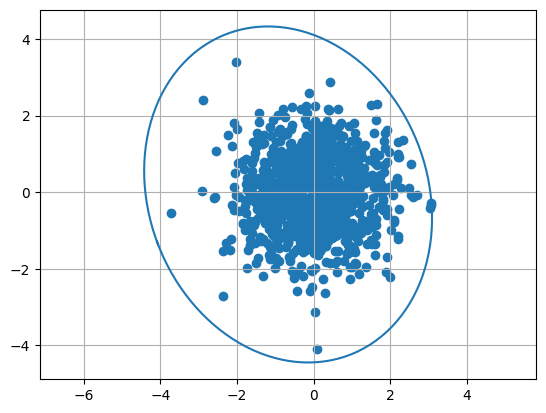

In [6]:
new_D = A_sf * D
new_D = np.diagflat(new_D)

fig = plt.figure()
ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
ax.grid('true')
ax.axis('equal')
scatter_nD(pts,ax)
ellipse_plot(P @ new_D @ P.T, c, ax)
plt.show()

#### Compute the low-res polyhedron that bounds the corrected ellipse

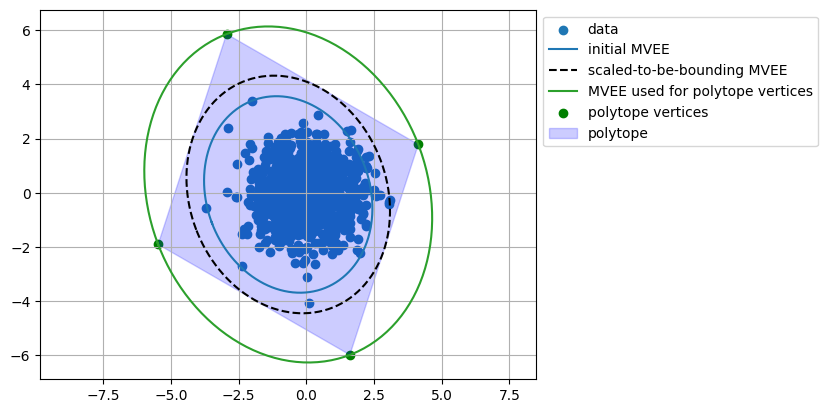

In [7]:
mesh_density = 3
V = get_mesh_vertices(nD,mesh_density) # polyhedron coordinates on a unit sphere

sf1 = scaling_factor(nD,mesh_density)
sf2 = radial_scaling_to_correct_undershoot
D_sf = sf1 * sf2
D_sqrt_inv = np.diagflat(1 / np.sqrt(D))
tm = P @ (D_sf * D_sqrt_inv)

V = (tm @ V.T) + c

if nD == 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
    ax.grid('true')
    ax.axis('equal')
    scatter_nD(pts,ax)

    ellipse_plot(A, c, ax)
    ellipse_plot(A_sf * A, c, ax)
    ellipse_plot(1 / D_sf**2 * A, c, ax)
    scatter_nD(V,ax)
    plot_polyhedron(V,ax)
    ax.lines[1].set_color('black')
    ax.lines[1].set_linestyle('--')
    ax.collections[1].set_color('green')
    ax.legend(['data','initial MVEE','scaled-to-be-bounding MVEE','MVEE used for polytope vertices','polytope vertices', 'polytope'], loc="upper left", bbox_to_anchor=(1, 1))
    
    plt.show()

elif nD == 3:
    plt.switch_backend('TkAgg')  # or 'Qt5Agg'
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
    ax.grid('true')
    ax.axis('equal')
    scatter_nD(pts,ax)
    
    # ellipse_plot(1 / D_sf**2 * A, c, ax)
    scatter_nD(V,ax)
    plot_polyhedron(V,ax)
    ax.view_init(90, -90) # → XY Plane (Top-down)
    # ax.view_init(0, -90) # → XZ Plane (Front view)
    # ax.view_init(0, 0) # → YZ Plane (Side view)

    plt.show(block=True)
    %matplotlib inline

#### LowResMVEE demo

LowResMVEE will handle the process described in this notebook.

##### 2D example

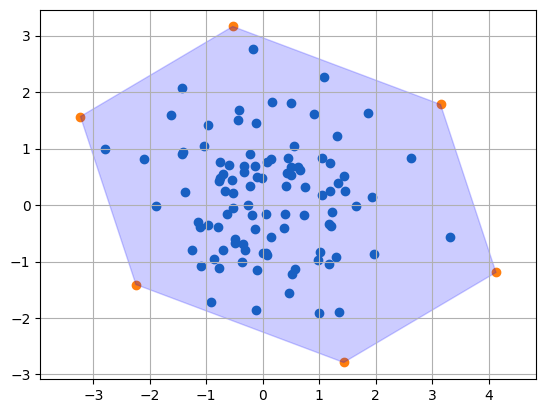

In [8]:
nD = 2
n_pts = 100
pts = np.random.randn(nD,n_pts)

lrMVEE = LowResMVEE(pts)
V = lrMVEE.vertices

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
ax.grid('true')
ax.axis('equal')
scatter_nD(pts,ax)
scatter_nD(V,ax)
plot_polyhedron(V,ax)
plt.show()

##### 3D example

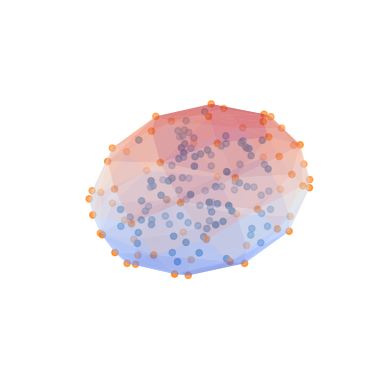

In [9]:
nD = 3
n_pts = 100
pts = np.random.rand(nD,n_pts)

lrMVEE = LowResMVEE(pts,max_n_verts=64)
V = lrMVEE.vertices

# Plot results
# %matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111, projection=None if nD < 3 else '3d')
ax.grid('true')
ax.axis('off')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.zaxis.set_ticks_position('none')
scatter_nD(pts,ax)
scatter_nD(V,ax)
plot_polyhedron(V,ax)
plt.show()
# %matplotlib inline

##### 4D example

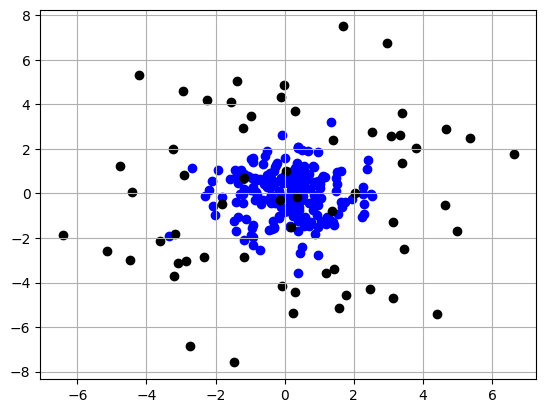

In [10]:
pts = np.random.randn(4,100)

lrMVEE = LowResMVEE(pts,max_n_verts=32)
V = lrMVEE.vertices

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid('true')
ax.axis('auto')
ax.scatter(pts[0,:],pts[1,:], c='b')
ax.scatter(pts[2,:],pts[3,:], c='b')
ax.scatter(V[0,:],V[1,:], c='k')
ax.scatter(V[2,:],V[3,:], c='k')
plt.show()

Finished 2D-1000pts
Finished 4D-1000pts
Finished 6D-1000pts
Finished 8D-1000pts
Finished 10D-1000pts
Finished 12D-1000pts


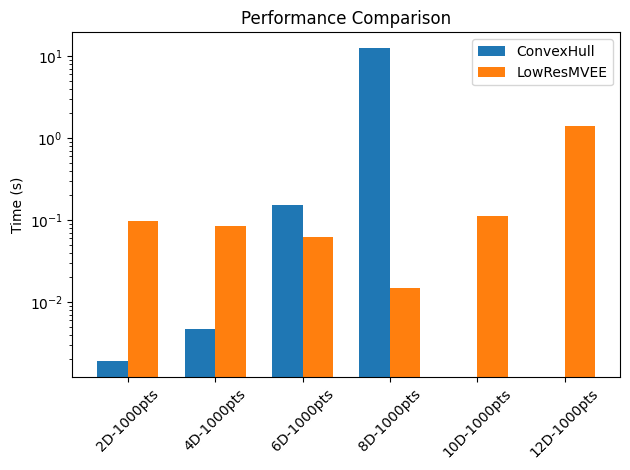

In [11]:
import time
from scipy.spatial import ConvexHull

dims = [2,4,6,8,10,12]
n_pts = [1000]

times_ch = []
times_mvee = []
labels = []

for nD in dims:
    for n in n_pts: 

        pts = np.random.randn(nD,n)

        if nD <= 8:
            start = time.perf_counter()
            ConvexHull(pts.T).vertices
            end = time.perf_counter()
            times_ch.append(end - start)
        else:
            times_ch.append(0)
        
        start = time.perf_counter()
        lrMVEE = LowResMVEE(pts,max_n_verts=2*nD) # cross polytope only
        V = lrMVEE.vertices
        end = time.perf_counter()
        times_mvee.append(end - start)

        labels.append(f"{nD}D-{n}pts")
        print("Finished " + labels[-1])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, times_ch, width, label='ConvexHull')
ax.bar(x + width/2, times_mvee, width, label='LowResMVEE')

ax.set_ylabel('Time (s)')
ax.set_yscale('log')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()